In [1]:
!pip install shap
!pip install eli5
import numpy as np
import pandas as pd
import shap
import pickle
import eli5
from eli5 import show_weights
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import metrics

In [2]:
cars = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
                  names = ["Buying", "Maintenance", "Doors", "Person", "Luggage boot", "Safety", "Class"])

In [3]:
#view the first five rows
cars.head()

,Buying,Maintenance,Doors,Person,Luggage boot,Safety,Class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
#checking for missing values
print (cars.isnull().sum())

Buying          0
Maintenance     0
Doors           0
Person          0
Luggage boot    0
Safety          0
Class           0
dtype: int64


In [5]:
#choosing dependent variable
Y = cars.Class
Y

0       unacc
1       unacc
2       unacc
3       unacc
4       unacc
        ...  
1723     good
1724    vgood
1725    unacc
1726     good
1727    vgood
Name: Class, Length: 1728, dtype: object

In [6]:
#subsetting the dependent variable to get the independent variables
X = cars.drop(['Class'], axis=1)
X

,Buying,Maintenance,Doors,Person,Luggage boot,Safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med
...,...,...,...,...,...,...
1723,low,low,5more,more,med,med
1724,low,low,5more,more,med,high
1725,low,low,5more,more,big,low
1726,low,low,5more,more,big,med


In [7]:
#changing strings to float so it can be fit into the model without throwing errors
X.iloc[:,0:2].replace({'low':0,'med':1/3,'high':2/3, 'vhigh':1}, inplace = True)
X.iloc[:,2].replace({'2':0,'3':1/3,'4':2/3,'5more':1},inplace = True)
X.iloc[:,3].replace({'2':0,'4':0.5,'more':1},inplace = True)
X.iloc[:,4].replace({'small':0,'med':0.5,'big':1},inplace = True)
X.iloc[:,5].replace({'low':0,'med':0.5,'high':1},inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#show the shape of the independent variables
X.shape

(1728, 6)

In [9]:
#save the independent variables in the col_features
col_features = X.columns.values
col_features

array(['Buying', 'Maintenance', 'Doors', 'Person', 'Luggage boot',
       'Safety'], dtype=object)

In [10]:
#show the shape of the target column
Y.shape

(1728,)

In [11]:
#importing the train-test split to be used for both models
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=45)
f_measure_score = {'decision_tree':{},'svm':{},'knn':{},'logistic':{}}

In [12]:
#setting aside the cross validation data
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=45)

In [13]:
#building the decision tree
parameter_tree = {'criterion':['entropy'],'max_depth':list(range(8,11)),'min_samples_leaf':list(range(1,4)),'random_state':[45]}
d_tree = DecisionTreeClassifier()
grid_tree = GridSearchCV(d_tree, parameter_tree, cv = cv, scoring='f1_micro')
grid_tree.fit(X_train,Y_train)
y_pred_tree = grid_tree.predict(X_test)
nested_score_tree = cross_val_score(grid_tree, X = X, y = Y, cv = cv) 
f_measure_score['decision_tree']['mean'] = np.mean(nested_score_tree)
f_measure_score['decision_tree']['std'] = np.std(nested_score_tree)

In [14]:
#print values of the classification from the decision tree model
print('precision,recall,f-measure\n', classification_report(Y_test,y_pred_tree))

precision,recall,f-measure
               precision    recall  f1-score   support

         acc       0.92      0.99      0.95        74
        good       0.87      0.87      0.87        15
       unacc       1.00      0.98      0.99       243
       vgood       1.00      1.00      1.00        14

    accuracy                           0.98       346
   macro avg       0.95      0.96      0.95       346
weighted avg       0.98      0.98      0.98       346



In [15]:
#Modelling the pipeline for the decision tree
X, Y = make_classification(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                     random_state=45)
pipe = Pipeline([('scaler', StandardScaler()), ('d_tree', DecisionTreeClassifier())])

# The pipeline can be used as any other estimator
# and this avoids leaking the test set into the train set
pipe.fit(X_train, Y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('d_tree', DecisionTreeClassifier())])
pipe.score(X_test, Y_test)

0.92

In [16]:
#best parameters of the decision tree
grid_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'random_state': 45}

In [17]:
#generating the ROC CURVE
parameter_tree = {'criterion':['entropy'],'max_depth':list(range(8,11)),'min_samples_leaf':list(range(1,4)),'random_state':[45]}
d_tree = DecisionTreeClassifier()
grid_tree = GridSearchCV(d_tree, parameter_tree, cv = cv, scoring='f1_micro')
d_tree.fit(X_train,Y_train)

# predict probabilities
pred_prob1 = d_tree.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(Y_test, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(Y_test, pred_prob1[:,1])

print(auc_score1)

0.9


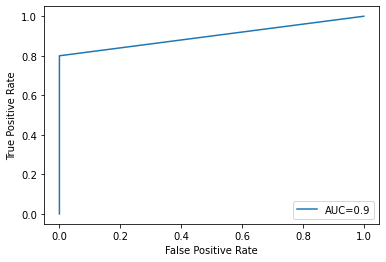

In [18]:
#Plotting the ROC curve
plt.plot(fpr1,tpr1,label="AUC="+str(auc_score1))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [19]:
#The AUC for this decision tree model turns out to be 0.9. 
#Since this is closest to 1.0, this confirms that the model does the BEST job of classifying data
#because the closer AUC is to 1, the better the model. 
#A model with an AUC equal to 0.5 is no better than a model that makes random classifications.

In [20]:
#generating feature importance
dtree_importance = d_tree.feature_importances_
# summarize feature importance
for i,v in enumerate(dtree_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.02541
Feature: 1, Score: 0.07395
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.75020
Feature: 4, Score: 0.04959
Feature: 5, Score: 0.04889
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.02679
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.02516
Feature: 19, Score: 0.00000


In [21]:
#using shap to explain feature importance

dtree_explainer = shap.TreeExplainer(d_tree)
shap_values = dtree_explainer.shap_values(X)

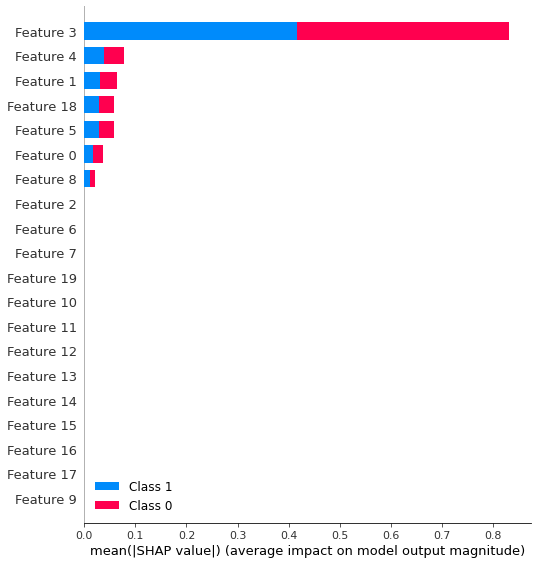

In [22]:
shap_values
shap.summary_plot(shap_values, X, plot_type='bar')

In [23]:
#using pickle to save model so it can be used for future purposes

# save the model to disk
decision_tree_model = 'finalized_model.sav'
pickle.dump(d_tree, open(decision_tree_model, 'wb'))

In [24]:
###LOGISTIC REGRESSION MODEL

#building the logistic regression model I used (100 and 1000 iterations but it could not complete so i stayed with 10 iterations)
parameter_log = {'C':[10]}
logistic = LogisticRegression(multi_class='multinomial',solver='lbfgs',penalty = 'l2',random_state = 45)
grid_log = GridSearchCV(logistic, parameter_log, cv = cv, scoring='f1_micro')
grid_log.fit(X_train, Y_train)
y_pred_log = grid_log.predict(X_test)
nested_score_log = cross_val_score(grid_log, X = X, y = Y, cv = cv) 
f_measure_score['logistic']['mean'] = np.mean(nested_score_log)
f_measure_score['logistic']['std'] = np.std(nested_score_log)

In [25]:
#print values of the classification from the logisitc regression model
print('precision,recall,f-measure\n', classification_report(Y_test,y_pred_log),'\n')

precision,recall,f-measure
               precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.62      0.80      0.70        10

    accuracy                           0.72        25
   macro avg       0.72      0.73      0.72        25
weighted avg       0.75      0.72      0.72        25
 



In [26]:
#Modelling the pipeline

X, Y = make_classification(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                     random_state=45)
pipe = Pipeline([('scaler', StandardScaler()), ('logisitic', LogisticRegression())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, Y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('logisitic', LogisticRegression())])
pipe.score(X_test, Y_test)

0.72

In [27]:
#best parameters of the logistic regression model
grid_log.best_params_

{'C': 10}

In [28]:
#creating the ROC CURVE for the logistic regression model
parameter_log = {'C':[10]}
logistic = LogisticRegression(multi_class='multinomial',solver='lbfgs',penalty = 'l2',random_state = 45)
grid_log = GridSearchCV(logistic, parameter_log, cv = cv, scoring='f1_micro')
logistic.fit(X_train, Y_train)

# predict probabilities
pred_prob2 = logistic.predict_proba(X_test)

# roc curve for models
fpr2, tpr2, thresh2 = roc_curve(Y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

# auc scores
auc_score2 = roc_auc_score(Y_test, pred_prob2[:,1])

print(auc_score2)

0.8200000000000001


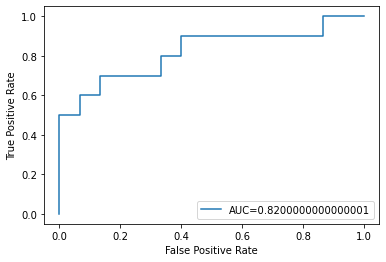

In [29]:
#plotting the ROC curve and calculating the Area under the curve
plt.plot(fpr2,tpr2,label="AUC="+str(auc_score2))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [30]:
#The AUC for this logistic regression model turns out to be 0.82. 
#Since this is close to 1.0, this confirms that the model does a GOOD job of classifying data.

In [31]:
# getting the feature importance
logistic_importance = logistic.coef_[0]
# summarize feature importance
for i,v in enumerate(logistic_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.40065
Feature: 1, Score: 0.37270
Feature: 2, Score: -0.22413
Feature: 3, Score: 0.98512
Feature: 4, Score: 0.81258
Feature: 5, Score: 0.32921
Feature: 6, Score: 0.27748
Feature: 7, Score: 0.41005
Feature: 8, Score: 0.32319
Feature: 9, Score: -0.39240
Feature: 10, Score: 0.73641
Feature: 11, Score: 0.35371
Feature: 12, Score: 0.24243
Feature: 13, Score: -0.01554
Feature: 14, Score: -0.10215
Feature: 15, Score: 0.06994
Feature: 16, Score: 0.46214
Feature: 17, Score: 0.24825
Feature: 18, Score: 0.34886
Feature: 19, Score: -0.34341


In [32]:
#using eli5 to explain feature importance

eli5.explain_weights(logistic)

Weight?,Feature
+0.985,x3
+0.813,x4
+0.736,x10
+0.581,<BIAS>
+0.462,x16
+0.410,x7
+0.401,x0
+0.373,x1
+0.354,x11
+0.349,x18


In [33]:
#using pickle to save model so it can be used for future purposes

# save the model to disk
logistic_regression_model = 'finalized_model.sav'
pickle.dump(logistic, open(logistic_regression_model, 'wb'))

In [34]:
###K-NEAREST NEIGHBOR MODEL

#Building the Knn model

para_knn = {'n_neighbors':list(range(12,17)),'weights':['uniform','distance']}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, para_knn, cv = cv, scoring='f1_micro')
grid_knn.fit(X_train,Y_train)
y_pred_knn = grid_knn.predict(X_test)
nested_score_knn = cross_val_score(grid_knn, X = X, y = Y, cv = cv) 
f_measure_score['knn']['mean'] = np.mean(nested_score_knn)
f_measure_score['knn']['std'] = np.std(nested_score_knn)

In [35]:
#Printing the classification of the knn model

print('precision,recall,f-measure\n', classification_report(Y_test,y_pred_knn))

precision,recall,f-measure
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.80      0.80      0.80        10

    accuracy                           0.84        25
   macro avg       0.83      0.83      0.83        25
weighted avg       0.84      0.84      0.84        25



In [36]:
#Modelling the Pipeline

X, Y = make_classification(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                     random_state=45)
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, Y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
pipe.score(X_test, Y_test)

0.6

In [37]:
#best parameter of the KNN model
grid_knn.best_params_

{'n_neighbors': 16, 'weights': 'distance'}

In [38]:
#Generating the ROC curve and calculating the Area under the curve

para_knn = {'n_neighbors':list(range(12,17)),'weights':['uniform','distance']}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, para_knn, cv = cv, scoring='f1_micro')
knn.fit(X_train,Y_train)

# predict probabilities
pred_prob3 = knn.predict_proba(X_test)

# roc curve for models
fpr3, tpr3, thresh3 = roc_curve(Y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

# auc scores
auc_score3 = roc_auc_score(Y_test, pred_prob3[:,1])

print(auc_score3)

0.8300000000000001


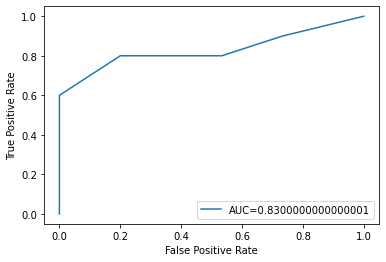

In [39]:
#plotting the ROC curve
plt.plot(fpr3,tpr3,label="AUC="+str(auc_score3))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [40]:
#The AUC for this knn model turns out to be 0.83. 
#Since this is close to 1.0, this confirms that the model does a GOOD job of classifying data.

In [41]:
# perform permutation importance to generate the feature importance of the model
results = permutation_importance(knn, X, Y, scoring='accuracy')
# get importance
knn_importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(knn_importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.03000
Feature: 1, Score: -0.02000
Feature: 2, Score: -0.02200
Feature: 3, Score: 0.07600
Feature: 4, Score: 0.06800
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.01600
Feature: 7, Score: -0.03200
Feature: 8, Score: -0.02200
Feature: 9, Score: -0.01800
Feature: 10, Score: 0.00600
Feature: 11, Score: -0.00400
Feature: 12, Score: 0.01400
Feature: 13, Score: -0.00200
Feature: 14, Score: -0.00600
Feature: 15, Score: -0.01800
Feature: 16, Score: 0.01000
Feature: 17, Score: -0.00600
Feature: 18, Score: -0.01400
Feature: 19, Score: 0.00600


In [42]:
#using shap to explain the feature importance

# Produce the SHAP values
knn_explainer = shap.KernelExplainer(knn.predict,X_test)
knn_shap_values = knn_explainer.shap_values(X_test)

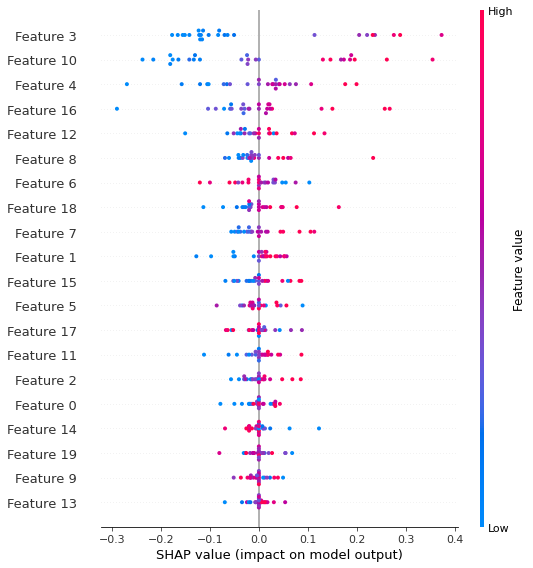

In [43]:
#plotting the SHAP values

shap.summary_plot(knn_shap_values, X_test)

In [44]:
#using pickle to save model so it can be used for future purposes

# save the model to disk
knn_model = 'finalized_model.sav'
pickle.dump(knn, open(knn_model, 'wb'))

In [45]:
### SVM MODEL

#Building the svm model

para_svm = {'kernel':['rbf'],'C':[10],'gamma':[5]} 
svm = SVC(random_state = 45,probability = True)
grid_svm = GridSearchCV(svm, para_svm, cv = cv, scoring='f1_micro')
grid_svm.fit(X_train, Y_train)
y_pred_svm = grid_svm.predict(X_test)
nested_score_svm = cross_val_score(grid_svm, X = X, y = Y, cv = cv) 
f_measure_score['svm']['mean'] = np.mean(nested_score_svm)
f_measure_score['svm']['std'] = np.std(nested_score_svm)

In [46]:
#printing the classification of the SVM model
print('precision,recall,f-measure\n', classification_report(Y_test,y_pred_svm),'\n')

precision,recall,f-measure
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.40      1.00      0.57        10

    accuracy                           0.40        25
   macro avg       0.20      0.50      0.29        25
weighted avg       0.16      0.40      0.23        25
 



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [47]:
#Modeling the pipeline

X, Y = make_classification(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                     random_state=45)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, Y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
pipe.score(X_test, Y_test)

0.72

In [48]:
#best parameters of the model

grid_svm.best_params_

{'C': 10, 'gamma': 5, 'kernel': 'rbf'}

In [49]:
#Creating the ROC and calculating the Area under the curve

para_svm = {'kernel':['rbf'],'C':[10],'gamma':[5]} 
svm = SVC(random_state = 45,probability = True)
grid_svm = GridSearchCV(svm, para_svm, cv = cv, scoring='f1_micro')
svm.fit(X_train, Y_train)

# predict probabilities
pred_prob4 = svm.predict_proba(X_test)

# roc curve for models
fpr4, tpr4, thresh4 = roc_curve(Y_test, pred_prob4[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(Y_test))]
p_fpr, p_tpr, _ = roc_curve(Y_test, random_probs, pos_label=1)

# auc scores
auc_score4 = roc_auc_score(Y_test, pred_prob4[:,1])

print(auc_score4)

0.8866666666666667


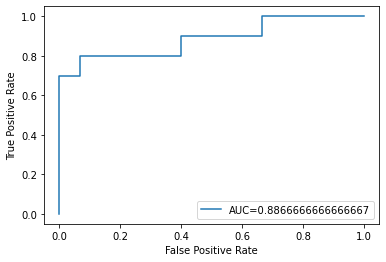

In [50]:
#Plotting the ROC curve
plt.plot(fpr4,tpr4,label="AUC="+str(auc_score4))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [51]:
#The AUC for this svm model turns out to be 0.89. 
#Since this is closer to 1.0, this confirms that the model does a BETTER job of classifying data.

In [52]:
 #get feature importance for the model
# The SHAP values
svm_explainer = shap.KernelExplainer(svm.predict,X_test)
svm_shap_values = svm_explainer.shap_values(X_test)

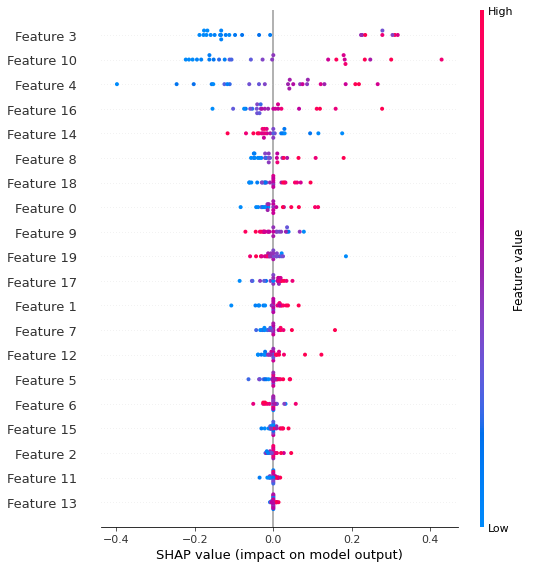

In [53]:
#plotting the SHAP values

shap.summary_plot(svm_shap_values, X_test)

In [54]:
#using pickle to save model so it can be used for future purposes

# save the model to disk
svm_model = 'finalized_model.sav'
pickle.dump(svm, open(svm_model, 'wb'))

In [55]:
#comparing the 4 models designed
for k,v in f_measure_score.items():
    print(k, ': ', v)

decision_tree :  {'mean': 0.9704731818792849, 'std': 0.013333939917099073}
svm :  {'mean': 0.54, 'std': 0.06633249580710798}
knn :  {'mean': 0.8300000000000001, 'std': 0.09}
logistic :  {'mean': 0.8200000000000001, 'std': 0.10770329614269009}


In [56]:
#the model with the best accuracy is the decision tree model
accuracy_tree = d_tree.score(X_test,Y_test)
print('accuracy of decisiontree: ', accuracy_tree)

accuracy of decisiontree:  0.92
